In [43]:
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
import glob
import matplotlib.pyplot as plt

In [44]:
# Import image paths
imagesRaw = glob.glob("./new_images/*.jpg")
imagesRaw.sort()

In [45]:
# Grab all the bounding box info
with open('boundingBoxes.txt', 'r') as f:
    lines = f.readlines()
 
boxes = [[float(x) for x in line.strip().split(",")] for line in lines]

In [59]:
# Create a new dataset, pairing images and respective boxes
imageDataSet = tf.data.Dataset.from_tensor_slices((imagesRaw, boxes))
# Shuffle the data
imageDataSet.shuffle(100)

<ShuffleDataset shapes: ((), (5,)), types: (tf.string, tf.float32)>

In [74]:
def load_jpeg(image, box):
    # Load the image turn into jpeg
    decoded = tf.io.read_file(image)
    imageTf = tf.image.decode_jpeg(decoded)
    # Normalize the images
    returnImage = tf.cast(imageTf, tf.float32) / 255.0
    returnImage = tf.reshape(returnImage, (488,488,3))
    return returnImage, box

# Plots two given images
def display(imageOne, imageTwo):
    plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imageOne))
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imageTwo))
    plt.axis("off")
    plt.show()

# Convert the yolo box format to tensor box format
def convertYolo(box):
    xMax = box[0]*488*2
    yMax = box[1]*488*2
    xMin = - box[2]*488 + xMax
    yMin = - box[3]*488 + yMax
    return xMax, yMax, xMin, yMin

In [75]:
# Convert the paths into actual images
entireSet = imageDataset.map(load_jpeg)

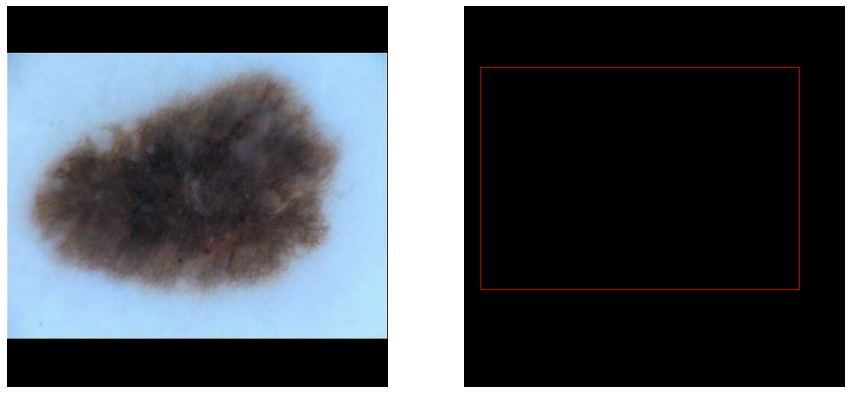

In [86]:
# Ensure the bounding boxes match the images
for image, box in entireSet.take(1):
    xMax, yMax, xMin, yMin = convertYolo(box)
    #Convert image to float32 (required for draw_bounding_boxes)
    boxImage = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Reshape to [batch, height, width, depth]
    boxImage = tf.reshape(boxImage, shape=[1, 488, 488, 3])
    box = tf.stack([yMin/488, xMin/488, yMax/488, xMax/488], axis=0)
    # Reshape to [batch, num_bounding_boxes, 4]
    box = tf.reshape(box, shape=[1,1,4])
    colors = [[255.0, 0.0, 1.0]]
    newImage = tf.image.draw_bounding_boxes(boxImage, box, colors)
    display(image, newImage.numpy()[0])

In [95]:
# Divide the dataset into train, test and validation
trainSize = int(0.8 * 2594)
valSize = int(0.1 * 2594)
train = entireSet.take(trainSize)
temp = entireSet.skip(trainSize)
test = temp.skip(valSize)
validation = temp.take(valSize)

In [96]:
# Create batches:
train_batches = train.batch(4)
test_batches = test.batch(4)
validation_batches = validation.batch(4)

In [97]:
# Define the constants
S = 3 # Divide the image to have S*S cells
C = 1 # Number of classes 
B = 2 # Number of bounding boxes to be predicted per cell

In [98]:
model = tf.keras.Sequential([
    #First Layer
    tf.keras.layers.Conv2D(64, (7,7), strides=(2, 2), activation=LeakyReLU(alpha=0.1),  input_shape=(488,488,3)), #padding=3?
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    
    #Second Layer
    tf.keras.layers.Conv2D(192, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    
    #Third Layer
    tf.keras.layers.Conv2D(128, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(256, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(256, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(512, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    
    #Fourth Layer
    # +++ Repeated block
    tf.keras.layers.Conv2D(256, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(512, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    
    tf.keras.layers.Conv2D(256, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(512, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),

    tf.keras.layers.Conv2D(256, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(512, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),

    tf.keras.layers.Conv2D(256, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(512, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    # +++ END BLOCK
    tf.keras.layers.Conv2D(512, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    
    #Fifth layer
    # +++ Repeated Block
    tf.keras.layers.Conv2D(512, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    
    tf.keras.layers.Conv2D(512, (1,1), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    # +++ END BLOCK
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(1024, (3,3), strides=(2, 2), activation=LeakyReLU(alpha=0.1), padding="same"),
    
    #Sixth Layer
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    tf.keras.layers.Conv2D(1024, (3,3), activation=LeakyReLU(alpha=0.1), padding="same"),
    
    # Final Output Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, input_shape=(1024 * S * S,), activation=LeakyReLU(alpha=0.1)),
    tf.keras.layers.Dense(S * S * (B*5+C), input_shape=(4096,), activation=None)
])

The yoloLoss function is an adpation from here: https://blog.emmanuelcaradec.com/humble-yolo-implementation-in-keras/. All credit goes to Emmanuel Caradec

In [144]:
def yoloLoss(y_true, y_pred):
    print(y_true)
    print(y_pred)
    grid = [ [[float(x),float(y)]]*B for y in range(S) for x in range(S)]

    pred_boxes = tf.reshape(y_pred[...,3:], (-1,S*S,B,5))
    true_boxes = tf.reshape(y_true[...,3:], (-1,S*S,B,5))
    y_true_conf = true_boxes[...,4]
    y_pred_conf = pred_boxes[...,4]

    y_pred_xy   = pred_boxes[...,0:2] + tf.Variable(grid)
    y_true_xy   = true_boxes[...,0:2]

    xy_loss    = tf.math.reduce_sum(tf.math.reduce_sum(tf.math.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)
    
    y_pred_wh   = pred_boxes[...,2:4]
    y_true_wh   = pred_boxes[...,2:4]
    y_true_conf = true_boxes[...,4]

    wh_loss    = tf.math.reduce_sum(tf.math.reduce_sum(tf.math.square(tf.math.sqrt(y_true_wh) - tf.math.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)
                                    
    y_true_class = y_true[...,0:2]
    y_pred_class = y_pred[...,0:2]
    y_true_conf = true_boxes[...,4]

    clss_loss  = tf.math.reduce_sum(tf.math.square(y_true_class - y_pred_class)*y_true_conf, axis=-1)
                                    
    intersect_wh = tf.math.maximum(tf.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - tf.math.abs(y_pred_xy - y_true_xy) )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    true_area = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area = y_pred_wh[...,0] * y_pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    iou = intersect_area / union_area

    conf_loss = tf.math.reduce_sum(tf.math.square(y_true_conf*iou - y_pred_conf)*y_true_conf, axis=-1)
    
    loss =  clss_loss + xy_loss + wh_loss + conf_loss
    
    x = rip
                                    
    return loss


In [145]:
# Implement custom metric: Jaccard 
def jaccardIndex(y_true, y_pred):
    # Computes the element wise multiplication then summation. i.e. calculate the area that overlaps
    numerator = (tf.math.reduce_sum(tf.math.multiply(y_true, y_pred)))
    # Calculate the area
    denom = tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_true) - numerator
    return numerator/denom

In [146]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=yoloLoss,
              metrics=[jaccardIndex])

In [147]:
history =  model.fit(train_batches, epochs=1, validation_data=validation_batches)

Tensor("IteratorGetNext:1", shape=(None, 5), dtype=float32)
Tensor("sequential_3/dense_8/BiasAdd:0", shape=(None, 99), dtype=float32)


NameError: in user code:

    C:\Users\e_gui\anaconda3\envs\tfEnv\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\e_gui\AppData\Local\Temp/ipykernel_3208/1757441669.py:39 yoloLoss  *
        x = rip

    NameError: name 'rip' is not defined
